In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                            | 0/50000 [00:00<?, ?it/s]

  9%|█████████▌                                                                                                    | 4364/50000 [00:00<00:01, 43637.75it/s]

 18%|███████████████████▎                                                                                          | 8804/50000 [00:00<00:00, 44084.36it/s]

 27%|████████████████████████████▉                                                                                | 13258/50000 [00:00<00:00, 44288.33it/s]

 35%|██████████████████████████████████████▌                                                                      | 17714/50000 [00:00<00:00, 44393.12it/s]

 44%|████████████████████████████████████████████████▎                                                            | 22154/50000 [00:00<00:00, 43704.33it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 26627/50000 [00:00<00:00, 44047.97it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 31039/50000 [00:00<00:00, 44068.16it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 35463/50000 [00:00<00:00, 44120.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 39948/50000 [00:00<00:00, 44346.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 44441/50000 [00:01<00:00, 44524.73it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 48894/50000 [00:01<00:00, 44491.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 44217.55it/s]

Files already downloaded and verified


  0%|                                                                                                                            | 0/10000 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████▍                                                               | 4219/10000 [00:00<00:00, 42184.31it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                | 8525/10000 [00:00<00:00, 42695.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42542.94it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 yk4jbpb0


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                              | 0/625 [00:00<?, ?it/s]

  0%|▏                                                                                                                     | 1/625 [00:00<06:23,  1.63it/s]

  1%|▊                                                                                                                     | 4/625 [00:00<01:34,  6.57it/s]

  1%|█▎                                                                                                                    | 7/625 [00:00<00:57, 10.74it/s]

  2%|█▊                                                                                                                   | 10/625 [00:01<00:43, 14.07it/s]

  2%|██▍                                                                                                                  | 13/625 [00:01<00:36, 16.66it/s]

  3%|██▉                                                                                                                  | 16/625 [00:01<00:32, 18.62it/s]

  3%|███▌                                                                                                                 | 19/625 [00:01<00:30, 20.06it/s]

  4%|████                                                                                                                 | 22/625 [00:01<00:28, 21.11it/s]

  4%|████▋                                                                                                                | 25/625 [00:01<00:27, 21.87it/s]

  4%|█████▏                                                                                                               | 28/625 [00:01<00:26, 22.42it/s]

  5%|█████▊                                                                                                               | 31/625 [00:01<00:26, 22.80it/s]

  5%|██████▎                                                                                                              | 34/625 [00:02<00:25, 23.09it/s]

  6%|██████▉                                                                                                              | 37/625 [00:02<00:25, 23.19it/s]

  6%|███████▍                                                                                                             | 40/625 [00:02<00:25, 23.29it/s]

  7%|████████                                                                                                             | 43/625 [00:02<00:24, 23.40it/s]

  7%|████████▌                                                                                                            | 46/625 [00:02<00:24, 23.48it/s]

  8%|█████████▏                                                                                                           | 49/625 [00:02<00:24, 23.54it/s]

  8%|█████████▋                                                                                                           | 52/625 [00:02<00:24, 23.60it/s]

  9%|██████████▎                                                                                                          | 55/625 [00:02<00:24, 23.67it/s]

  9%|██████████▊                                                                                                          | 58/625 [00:03<00:23, 23.73it/s]

 10%|███████████▍                                                                                                         | 61/625 [00:03<00:23, 23.76it/s]

 10%|███████████▉                                                                                                         | 64/625 [00:03<00:23, 23.77it/s]

 11%|████████████▌                                                                                                        | 67/625 [00:03<00:23, 23.69it/s]

 11%|█████████████                                                                                                        | 70/625 [00:03<00:23, 23.74it/s]

 12%|█████████████▋                                                                                                       | 73/625 [00:03<00:23, 23.75it/s]

 12%|██████████████▏                                                                                                      | 76/625 [00:03<00:23, 23.76it/s]

 13%|██████████████▊                                                                                                      | 79/625 [00:03<00:22, 23.79it/s]

 13%|███████████████▎                                                                                                     | 82/625 [00:04<00:22, 23.81it/s]

 14%|███████████████▉                                                                                                     | 85/625 [00:04<00:22, 23.81it/s]

 14%|████████████████▍                                                                                                    | 88/625 [00:04<00:22, 23.82it/s]

 15%|█████████████████                                                                                                    | 91/625 [00:04<00:22, 23.82it/s]

 15%|█████████████████▌                                                                                                   | 94/625 [00:04<00:22, 23.81it/s]

 16%|██████████████████▏                                                                                                  | 97/625 [00:04<00:22, 23.72it/s]

 16%|██████████████████▌                                                                                                 | 100/625 [00:04<00:22, 23.74it/s]

 16%|███████████████████                                                                                                 | 103/625 [00:04<00:21, 23.76it/s]

 17%|███████████████████▋                                                                                                | 106/625 [00:05<00:21, 23.76it/s]

 17%|████████████████████▏                                                                                               | 109/625 [00:05<00:21, 23.77it/s]

 18%|████████████████████▊                                                                                               | 112/625 [00:05<00:21, 23.79it/s]

 18%|█████████████████████▎                                                                                              | 115/625 [00:05<00:21, 23.79it/s]

 19%|█████████████████████▉                                                                                              | 118/625 [00:05<00:21, 23.79it/s]

 19%|██████████████████████▍                                                                                             | 121/625 [00:05<00:21, 23.76it/s]

 20%|███████████████████████                                                                                             | 124/625 [00:05<00:21, 23.78it/s]

 20%|███████████████████████▌                                                                                            | 127/625 [00:05<00:20, 23.78it/s]

 21%|████████████████████████▏                                                                                           | 130/625 [00:06<00:20, 23.78it/s]

 21%|████████████████████████▋                                                                                           | 133/625 [00:06<00:20, 23.78it/s]

 22%|█████████████████████████▏                                                                                          | 136/625 [00:06<00:20, 23.78it/s]

 22%|█████████████████████████▊                                                                                          | 139/625 [00:06<00:20, 23.77it/s]

 23%|██████████████████████████▎                                                                                         | 142/625 [00:06<00:20, 23.77it/s]

 23%|██████████████████████████▉                                                                                         | 145/625 [00:06<00:20, 23.77it/s]

 24%|███████████████████████████▍                                                                                        | 148/625 [00:06<00:20, 23.77it/s]

 24%|████████████████████████████                                                                                        | 151/625 [00:06<00:19, 23.77it/s]

 25%|████████████████████████████▌                                                                                       | 154/625 [00:07<00:19, 23.75it/s]

 25%|█████████████████████████████▏                                                                                      | 157/625 [00:07<00:19, 23.75it/s]

 26%|█████████████████████████████▋                                                                                      | 160/625 [00:07<00:19, 23.76it/s]

 26%|██████████████████████████████▎                                                                                     | 163/625 [00:07<00:19, 23.75it/s]

 27%|██████████████████████████████▊                                                                                     | 166/625 [00:07<00:19, 23.75it/s]

 27%|███████████████████████████████▎                                                                                    | 169/625 [00:07<00:19, 23.75it/s]

 28%|███████████████████████████████▉                                                                                    | 172/625 [00:07<00:19, 23.75it/s]

 28%|████████████████████████████████▍                                                                                   | 175/625 [00:07<00:18, 23.75it/s]

 28%|█████████████████████████████████                                                                                   | 178/625 [00:08<00:18, 23.74it/s]

 29%|█████████████████████████████████▌                                                                                  | 181/625 [00:08<00:18, 23.75it/s]

 29%|██████████████████████████████████▏                                                                                 | 184/625 [00:08<00:18, 23.60it/s]

 30%|██████████████████████████████████▋                                                                                 | 187/625 [00:08<00:18, 23.65it/s]

 30%|███████████████████████████████████▎                                                                                | 190/625 [00:08<00:18, 23.68it/s]

 31%|███████████████████████████████████▊                                                                                | 193/625 [00:08<00:18, 23.70it/s]

 31%|████████████████████████████████████▍                                                                               | 196/625 [00:08<00:18, 23.69it/s]

 32%|████████████████████████████████████▉                                                                               | 199/625 [00:08<00:17, 23.71it/s]

 32%|█████████████████████████████████████▍                                                                              | 202/625 [00:09<00:17, 23.72it/s]

 33%|██████████████████████████████████████                                                                              | 205/625 [00:09<00:17, 23.73it/s]

 33%|██████████████████████████████████████▌                                                                             | 208/625 [00:09<00:17, 23.74it/s]

 34%|███████████████████████████████████████▏                                                                            | 211/625 [00:09<00:17, 23.73it/s]

 34%|███████████████████████████████████████▋                                                                            | 214/625 [00:09<00:17, 23.62it/s]

 35%|████████████████████████████████████████▎                                                                           | 217/625 [00:09<00:17, 23.65it/s]

 35%|████████████████████████████████████████▊                                                                           | 220/625 [00:09<00:17, 23.67it/s]

 36%|█████████████████████████████████████████▍                                                                          | 223/625 [00:09<00:16, 23.66it/s]

 36%|█████████████████████████████████████████▉                                                                          | 226/625 [00:10<00:16, 23.68it/s]

 37%|██████████████████████████████████████████▌                                                                         | 229/625 [00:10<00:16, 23.69it/s]

 37%|███████████████████████████████████████████                                                                         | 232/625 [00:10<00:16, 23.70it/s]

 38%|███████████████████████████████████████████▌                                                                        | 235/625 [00:10<00:16, 23.70it/s]

 38%|████████████████████████████████████████████▏                                                                       | 238/625 [00:10<00:16, 23.70it/s]

 39%|████████████████████████████████████████████▋                                                                       | 241/625 [00:10<00:16, 23.72it/s]

 39%|█████████████████████████████████████████████▎                                                                      | 244/625 [00:10<00:16, 23.67it/s]

 40%|█████████████████████████████████████████████▊                                                                      | 247/625 [00:10<00:15, 23.64it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 250/625 [00:11<00:15, 23.59it/s]

 40%|██████████████████████████████████████████████▉                                                                     | 253/625 [00:11<00:15, 23.59it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 256/625 [00:11<00:15, 23.59it/s]

 41%|████████████████████████████████████████████████                                                                    | 259/625 [00:11<00:15, 23.58it/s]

 42%|████████████████████████████████████████████████▋                                                                   | 262/625 [00:11<00:15, 23.58it/s]

 42%|█████████████████████████████████████████████████▏                                                                  | 265/625 [00:11<00:15, 23.57it/s]

 43%|█████████████████████████████████████████████████▋                                                                  | 268/625 [00:11<00:15, 23.57it/s]

 43%|██████████████████████████████████████████████████▎                                                                 | 271/625 [00:12<00:15, 23.57it/s]

 44%|██████████████████████████████████████████████████▊                                                                 | 274/625 [00:12<00:14, 23.57it/s]

 44%|███████████████████████████████████████████████████▍                                                                | 277/625 [00:12<00:14, 23.57it/s]

 45%|███████████████████████████████████████████████████▉                                                                | 280/625 [00:12<00:14, 23.45it/s]

 45%|████████████████████████████████████████████████████▌                                                               | 283/625 [00:12<00:14, 23.46it/s]

 46%|█████████████████████████████████████████████████████                                                               | 286/625 [00:12<00:14, 23.50it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 289/625 [00:12<00:14, 23.51it/s]

 47%|██████████████████████████████████████████████████████▏                                                             | 292/625 [00:12<00:14, 23.52it/s]

 47%|██████████████████████████████████████████████████████▊                                                             | 295/625 [00:13<00:14, 23.53it/s]

 48%|███████████████████████████████████████████████████████▎                                                            | 298/625 [00:13<00:13, 23.53it/s]

 48%|███████████████████████████████████████████████████████▊                                                            | 301/625 [00:13<00:13, 23.54it/s]

 49%|████████████████████████████████████████████████████████▍                                                           | 304/625 [00:13<00:13, 23.54it/s]

 49%|████████████████████████████████████████████████████████▉                                                           | 307/625 [00:13<00:13, 23.53it/s]

 50%|█████████████████████████████████████████████████████████▌                                                          | 310/625 [00:13<00:13, 23.53it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 313/625 [00:13<00:13, 23.54it/s]

 51%|██████████████████████████████████████████████████████████▋                                                         | 316/625 [00:13<00:13, 23.55it/s]

 51%|███████████████████████████████████████████████████████████▏                                                        | 319/625 [00:14<00:12, 23.54it/s]

 52%|███████████████████████████████████████████████████████████▊                                                        | 322/625 [00:14<00:12, 23.54it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 325/625 [00:14<00:12, 23.54it/s]

 52%|████████████████████████████████████████████████████████████▉                                                       | 328/625 [00:14<00:12, 23.54it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 331/625 [00:14<00:12, 23.52it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                      | 334/625 [00:14<00:12, 23.52it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                     | 337/625 [00:14<00:12, 23.52it/s]

 54%|███████████████████████████████████████████████████████████████                                                     | 340/625 [00:14<00:12, 23.52it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                    | 343/625 [00:15<00:11, 23.52it/s]

 55%|████████████████████████████████████████████████████████████████▏                                                   | 346/625 [00:15<00:11, 23.52it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                   | 349/625 [00:15<00:11, 23.41it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                  | 352/625 [00:15<00:11, 23.42it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                  | 355/625 [00:15<00:11, 23.44it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                 | 358/625 [00:15<00:11, 23.45it/s]

 58%|███████████████████████████████████████████████████████████████████                                                 | 361/625 [00:15<00:11, 23.45it/s]

 58%|███████████████████████████████████████████████████████████████████▌                                                | 364/625 [00:15<00:11, 23.46it/s]

 59%|████████████████████████████████████████████████████████████████████                                                | 367/625 [00:16<00:10, 23.47it/s]

 59%|████████████████████████████████████████████████████████████████████▋                                               | 370/625 [00:16<00:10, 23.49it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                              | 373/625 [00:16<00:10, 23.49it/s]

 60%|█████████████████████████████████████████████████████████████████████▊                                              | 376/625 [00:16<00:10, 23.51it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                             | 379/625 [00:16<00:10, 23.51it/s]

 61%|██████████████████████████████████████████████████████████████████████▉                                             | 382/625 [00:16<00:10, 23.50it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                            | 385/625 [00:16<00:10, 23.48it/s]

 62%|████████████████████████████████████████████████████████████████████████                                            | 388/625 [00:16<00:10, 23.49it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                           | 391/625 [00:17<00:09, 23.49it/s]

 63%|█████████████████████████████████████████████████████████████████████████▏                                          | 394/625 [00:17<00:09, 23.49it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                          | 397/625 [00:17<00:09, 23.50it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 400/625 [00:17<00:09, 23.50it/s]

 64%|██████████████████████████████████████████████████████████████████████████▊                                         | 403/625 [00:17<00:09, 23.49it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                        | 406/625 [00:17<00:09, 23.51it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                        | 409/625 [00:17<00:09, 23.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                       | 412/625 [00:18<00:09, 23.56it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                       | 415/625 [00:18<00:08, 23.58it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 418/625 [00:18<00:08, 23.57it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 421/625 [00:18<00:08, 23.60it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 424/625 [00:18<00:08, 23.61it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 427/625 [00:18<00:08, 23.62it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 430/625 [00:18<00:08, 23.62it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 433/625 [00:18<00:08, 23.62it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 436/625 [00:19<00:07, 23.63it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 439/625 [00:19<00:07, 23.63it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 442/625 [00:19<00:07, 23.63it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 445/625 [00:19<00:07, 23.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 448/625 [00:19<00:07, 23.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 451/625 [00:19<00:07, 23.59it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 454/625 [00:19<00:07, 23.58it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 457/625 [00:19<00:07, 23.61it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 460/625 [00:20<00:06, 23.62it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 463/625 [00:20<00:06, 23.63it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 466/625 [00:20<00:06, 23.62it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 469/625 [00:20<00:06, 23.63it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 472/625 [00:20<00:06, 23.63it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 475/625 [00:20<00:06, 23.64it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 478/625 [00:20<00:06, 23.64it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 481/625 [00:20<00:06, 23.64it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 484/625 [00:21<00:05, 23.63it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 487/625 [00:21<00:05, 23.57it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 490/625 [00:21<00:05, 23.59it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 493/625 [00:21<00:05, 23.60it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 496/625 [00:21<00:05, 23.61it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 499/625 [00:21<00:05, 23.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 502/625 [00:21<00:05, 23.62it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 505/625 [00:21<00:05, 23.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 508/625 [00:22<00:04, 23.62it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 511/625 [00:22<00:04, 23.60it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                    | 514/625 [00:22<00:04, 23.62it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 517/625 [00:22<00:04, 23.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 520/625 [00:22<00:04, 23.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 523/625 [00:22<00:04, 23.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 526/625 [00:22<00:04, 23.57it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 529/625 [00:22<00:04, 23.59it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 532/625 [00:23<00:03, 23.60it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 535/625 [00:23<00:03, 23.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 538/625 [00:23<00:03, 23.61it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 541/625 [00:23<00:03, 23.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 544/625 [00:23<00:03, 23.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 547/625 [00:23<00:03, 23.58it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 550/625 [00:23<00:03, 23.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 553/625 [00:23<00:03, 23.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 556/625 [00:24<00:02, 23.39it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 559/625 [00:24<00:02, 23.41it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 562/625 [00:24<00:02, 23.43it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 565/625 [00:24<00:02, 23.43it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 568/625 [00:24<00:02, 23.44it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 571/625 [00:24<00:02, 23.44it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 574/625 [00:24<00:02, 23.40it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 577/625 [00:25<00:02, 23.42it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 580/625 [00:25<00:01, 23.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 583/625 [00:25<00:01, 23.45it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 586/625 [00:25<00:01, 23.45it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 589/625 [00:25<00:01, 23.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 592/625 [00:25<00:01, 23.45it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 595/625 [00:25<00:01, 23.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 598/625 [00:25<00:01, 23.45it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 601/625 [00:26<00:01, 23.45it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 604/625 [00:26<00:00, 23.47it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 607/625 [00:26<00:00, 23.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 610/625 [00:26<00:00, 23.52it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 613/625 [00:26<00:00, 23.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 616/625 [00:26<00:00, 23.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 619/625 [00:26<00:00, 23.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [00:26<00:00, 23.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:27<00:00, 23.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:27<00:00, 23.09it/s]

train - OK


  0%|                                                                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▊                                                                                                                     | 1/157 [00:00<00:23,  6.60it/s]

  3%|███                                                                                                                   | 4/157 [00:00<00:09, 15.58it/s]

  4%|█████▎                                                                                                                | 7/157 [00:00<00:07, 18.95it/s]

  6%|███████▍                                                                                                             | 10/157 [00:00<00:07, 20.63it/s]

  8%|█████████▋                                                                                                           | 13/157 [00:00<00:06, 21.59it/s]

 10%|███████████▉                                                                                                         | 16/157 [00:00<00:06, 22.18it/s]

 12%|██████████████▏                                                                                                      | 19/157 [00:00<00:06, 22.56it/s]

 14%|████████████████▍                                                                                                    | 22/157 [00:01<00:05, 22.81it/s]

 16%|██████████████████▋                                                                                                  | 25/157 [00:01<00:05, 22.97it/s]

 18%|████████████████████▊                                                                                                | 28/157 [00:01<00:05, 23.09it/s]

 20%|███████████████████████                                                                                              | 31/157 [00:01<00:05, 23.17it/s]

 22%|█████████████████████████▎                                                                                           | 34/157 [00:01<00:05, 23.21it/s]

 24%|███████████████████████████▌                                                                                         | 37/157 [00:01<00:05, 23.24it/s]

 25%|█████████████████████████████▊                                                                                       | 40/157 [00:01<00:05, 23.27it/s]

 27%|████████████████████████████████                                                                                     | 43/157 [00:01<00:04, 23.29it/s]

 29%|██████████████████████████████████▎                                                                                  | 46/157 [00:02<00:04, 23.27it/s]

 31%|████████████████████████████████████▌                                                                                | 49/157 [00:02<00:04, 23.28it/s]

 33%|██████████████████████████████████████▊                                                                              | 52/157 [00:02<00:04, 23.29it/s]

 35%|████████████████████████████████████████▉                                                                            | 55/157 [00:02<00:04, 23.31it/s]

 37%|███████████████████████████████████████████▏                                                                         | 58/157 [00:02<00:04, 23.32it/s]

 39%|█████████████████████████████████████████████▍                                                                       | 61/157 [00:02<00:04, 23.32it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 64/157 [00:02<00:03, 23.32it/s]

 43%|█████████████████████████████████████████████████▉                                                                   | 67/157 [00:02<00:03, 23.33it/s]

 45%|████████████████████████████████████████████████████▏                                                                | 70/157 [00:03<00:03, 23.34it/s]

 46%|██████████████████████████████████████████████████████▍                                                              | 73/157 [00:03<00:03, 23.34it/s]

 48%|████████████████████████████████████████████████████████▋                                                            | 76/157 [00:03<00:03, 23.34it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 79/157 [00:03<00:03, 23.34it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 82/157 [00:03<00:03, 23.34it/s]

 54%|███████████████████████████████████████████████████████████████▎                                                     | 85/157 [00:03<00:03, 23.34it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 88/157 [00:03<00:02, 23.31it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 91/157 [00:04<00:02, 23.32it/s]

 60%|██████████████████████████████████████████████████████████████████████                                               | 94/157 [00:04<00:02, 23.31it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 97/157 [00:04<00:02, 23.33it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 100/157 [00:04<00:02, 23.34it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                        | 103/157 [00:04<00:02, 23.35it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 106/157 [00:04<00:02, 23.35it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 109/157 [00:04<00:02, 23.35it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 112/157 [00:04<00:01, 23.35it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 115/157 [00:05<00:01, 23.35it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 118/157 [00:05<00:01, 23.34it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 121/157 [00:05<00:01, 23.34it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 124/157 [00:05<00:01, 23.34it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 127/157 [00:05<00:01, 23.30it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 130/157 [00:05<00:01, 23.28it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 133/157 [00:05<00:01, 23.30it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 136/157 [00:05<00:00, 23.31it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 139/157 [00:06<00:00, 23.32it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 142/157 [00:06<00:00, 23.33it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 145/157 [00:06<00:00, 23.33it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [00:06<00:00, 23.33it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [00:06<00:00, 23.34it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [00:06<00:00, 23.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.73it/s]

val - OK


  0%|                                                                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▊                                                                                                                     | 1/157 [00:00<00:25,  6.04it/s]

  3%|███                                                                                                                   | 4/157 [00:00<00:10, 15.10it/s]

  4%|█████▎                                                                                                                | 7/157 [00:00<00:08, 18.68it/s]

  6%|███████▍                                                                                                             | 10/157 [00:00<00:07, 20.46it/s]

  8%|█████████▋                                                                                                           | 13/157 [00:00<00:06, 21.52it/s]

 10%|███████████▉                                                                                                         | 16/157 [00:00<00:06, 22.18it/s]

 12%|██████████████▏                                                                                                      | 19/157 [00:00<00:06, 22.61it/s]

 14%|████████████████▍                                                                                                    | 22/157 [00:01<00:05, 22.89it/s]

 16%|██████████████████▋                                                                                                  | 25/157 [00:01<00:05, 23.08it/s]

 18%|████████████████████▊                                                                                                | 28/157 [00:01<00:05, 23.20it/s]

 20%|███████████████████████                                                                                              | 31/157 [00:01<00:05, 23.28it/s]

 22%|█████████████████████████▎                                                                                           | 34/157 [00:01<00:05, 23.33it/s]

 24%|███████████████████████████▌                                                                                         | 37/157 [00:01<00:05, 23.38it/s]

 25%|█████████████████████████████▊                                                                                       | 40/157 [00:01<00:04, 23.41it/s]

 27%|████████████████████████████████                                                                                     | 43/157 [00:01<00:04, 23.44it/s]

 29%|██████████████████████████████████▎                                                                                  | 46/157 [00:02<00:04, 23.47it/s]

 31%|████████████████████████████████████▌                                                                                | 49/157 [00:02<00:04, 23.46it/s]

 33%|██████████████████████████████████████▊                                                                              | 52/157 [00:02<00:04, 23.46it/s]

 35%|████████████████████████████████████████▉                                                                            | 55/157 [00:02<00:04, 23.46it/s]

 37%|███████████████████████████████████████████▏                                                                         | 58/157 [00:02<00:04, 23.47it/s]

 39%|█████████████████████████████████████████████▍                                                                       | 61/157 [00:02<00:04, 23.48it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 64/157 [00:02<00:03, 23.45it/s]

 43%|█████████████████████████████████████████████████▉                                                                   | 67/157 [00:02<00:03, 23.42it/s]

 45%|████████████████████████████████████████████████████▏                                                                | 70/157 [00:03<00:03, 23.41it/s]

 46%|██████████████████████████████████████████████████████▍                                                              | 73/157 [00:03<00:03, 23.38it/s]

 48%|████████████████████████████████████████████████████████▋                                                            | 76/157 [00:03<00:03, 23.38it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 79/157 [00:03<00:03, 23.38it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 82/157 [00:03<00:03, 23.37it/s]

 54%|███████████████████████████████████████████████████████████████▎                                                     | 85/157 [00:03<00:03, 23.36it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 88/157 [00:03<00:02, 23.39it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 91/157 [00:04<00:02, 23.40it/s]

 60%|██████████████████████████████████████████████████████████████████████                                               | 94/157 [00:04<00:02, 23.42it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 97/157 [00:04<00:02, 23.45it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 100/157 [00:04<00:02, 23.48it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                        | 103/157 [00:04<00:02, 23.49it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 106/157 [00:04<00:02, 23.49it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 109/157 [00:04<00:02, 23.50it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 112/157 [00:04<00:01, 23.49it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 115/157 [00:05<00:01, 23.49it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 118/157 [00:05<00:01, 23.50it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 121/157 [00:05<00:01, 23.49it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 124/157 [00:05<00:01, 23.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 127/157 [00:05<00:01, 23.50it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 130/157 [00:05<00:01, 23.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 133/157 [00:05<00:01, 23.44it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 136/157 [00:05<00:00, 23.45it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 139/157 [00:06<00:00, 23.47it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 142/157 [00:06<00:00, 23.49it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 145/157 [00:06<00:00, 23.50it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [00:06<00:00, 23.50it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [00:06<00:00, 23.50it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [00:06<00:00, 23.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.93it/s]

test InD - OK


  0%|                                                                                                                              | 0/100 [00:00<?, ?it/s]

  3%|███▌                                                                                                                  | 3/100 [00:00<00:03, 24.78it/s]

  6%|███████                                                                                                               | 6/100 [00:00<00:03, 25.11it/s]

  9%|██████████▌                                                                                                           | 9/100 [00:00<00:03, 25.21it/s]

 12%|██████████████                                                                                                       | 12/100 [00:00<00:03, 25.28it/s]

 15%|█████████████████▌                                                                                                   | 15/100 [00:00<00:03, 25.21it/s]

 18%|█████████████████████                                                                                                | 18/100 [00:00<00:03, 25.26it/s]

 21%|████████████████████████▌                                                                                            | 21/100 [00:00<00:03, 25.30it/s]

 24%|████████████████████████████                                                                                         | 24/100 [00:00<00:03, 25.32it/s]

 27%|███████████████████████████████▌                                                                                     | 27/100 [00:01<00:02, 25.34it/s]

 30%|███████████████████████████████████                                                                                  | 30/100 [00:01<00:02, 25.36it/s]

 33%|██████████████████████████████████████▌                                                                              | 33/100 [00:01<00:02, 25.38it/s]

 36%|██████████████████████████████████████████                                                                           | 36/100 [00:01<00:02, 25.39it/s]

 39%|█████████████████████████████████████████████▋                                                                       | 39/100 [00:01<00:02, 25.41it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 42/100 [00:01<00:02, 25.42it/s]

 45%|████████████████████████████████████████████████████▋                                                                | 45/100 [00:01<00:02, 25.40it/s]

 48%|████████████████████████████████████████████████████████▏                                                            | 48/100 [00:01<00:02, 25.41it/s]

 51%|███████████████████████████████████████████████████████████▋                                                         | 51/100 [00:02<00:01, 25.42it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                     | 54/100 [00:02<00:01, 25.44it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                  | 57/100 [00:02<00:01, 25.43it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 60/100 [00:02<00:01, 25.36it/s]

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 63/100 [00:02<00:01, 25.38it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 66/100 [00:02<00:01, 25.39it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▋                                    | 69/100 [00:02<00:01, 25.41it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 72/100 [00:02<00:01, 25.41it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 75/100 [00:02<00:00, 25.41it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 78/100 [00:03<00:00, 25.42it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 81/100 [00:03<00:00, 25.42it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 84/100 [00:03<00:00, 25.41it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 87/100 [00:03<00:00, 25.43it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 90/100 [00:03<00:00, 25.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 93/100 [00:03<00:00, 25.45it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [00:03<00:00, 25.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [00:03<00:00, 25.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.38it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(40000, 3, 32, 32) (40000, 512) (40000, 2560) (40000, 3, 32, 32) (40000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(6400, 3, 32, 32) (6400, 512) (6400, 2560) (6400, 3, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


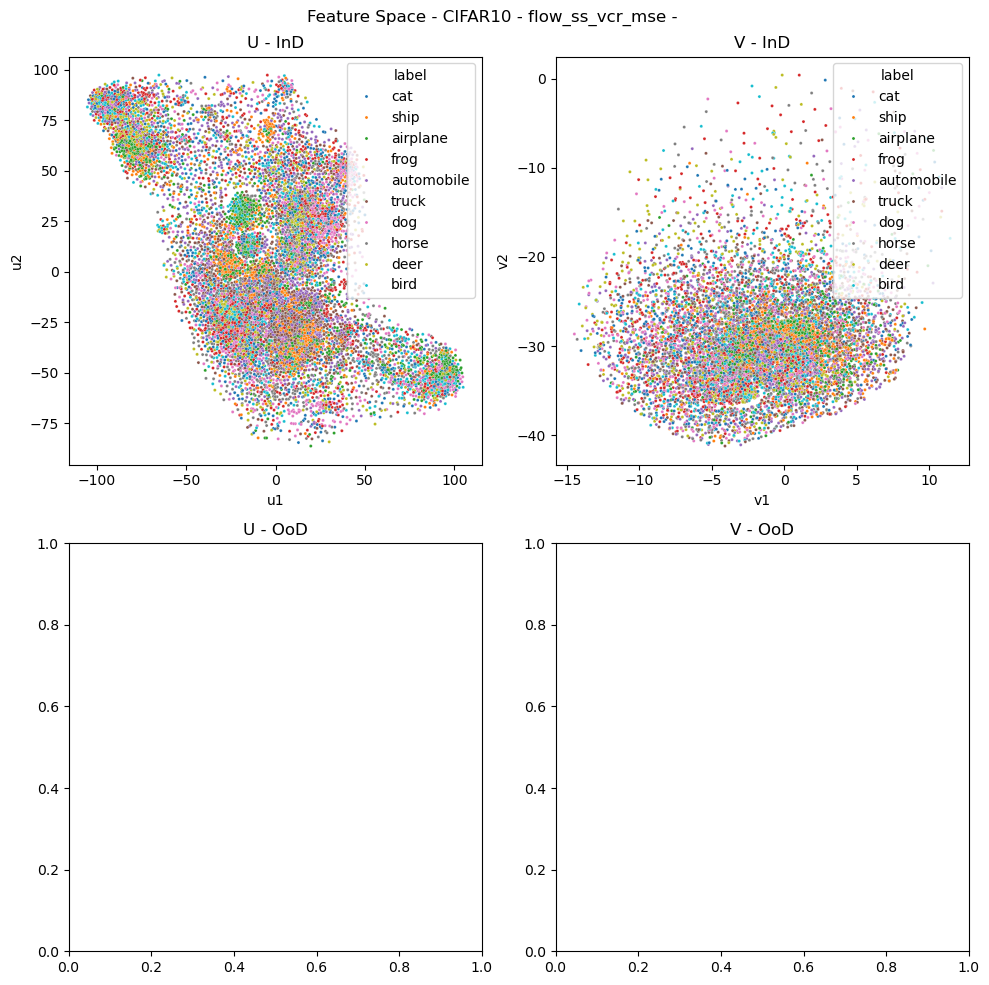

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████                                                                                          | 1/4 [00:00<00:02,  1.29it/s]

 50%|████████████████████████████████████████████████████████████                                                            | 2/4 [00:01<00:01,  1.28it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 3/4 [00:02<00:00,  1.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]

  0%|                                                                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████                                                                                          | 1/4 [00:03<00:09,  3.28s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 2/4 [00:06<00:06,  3.28s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 3/4 [00:09<00:03,  3.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.31s/it]

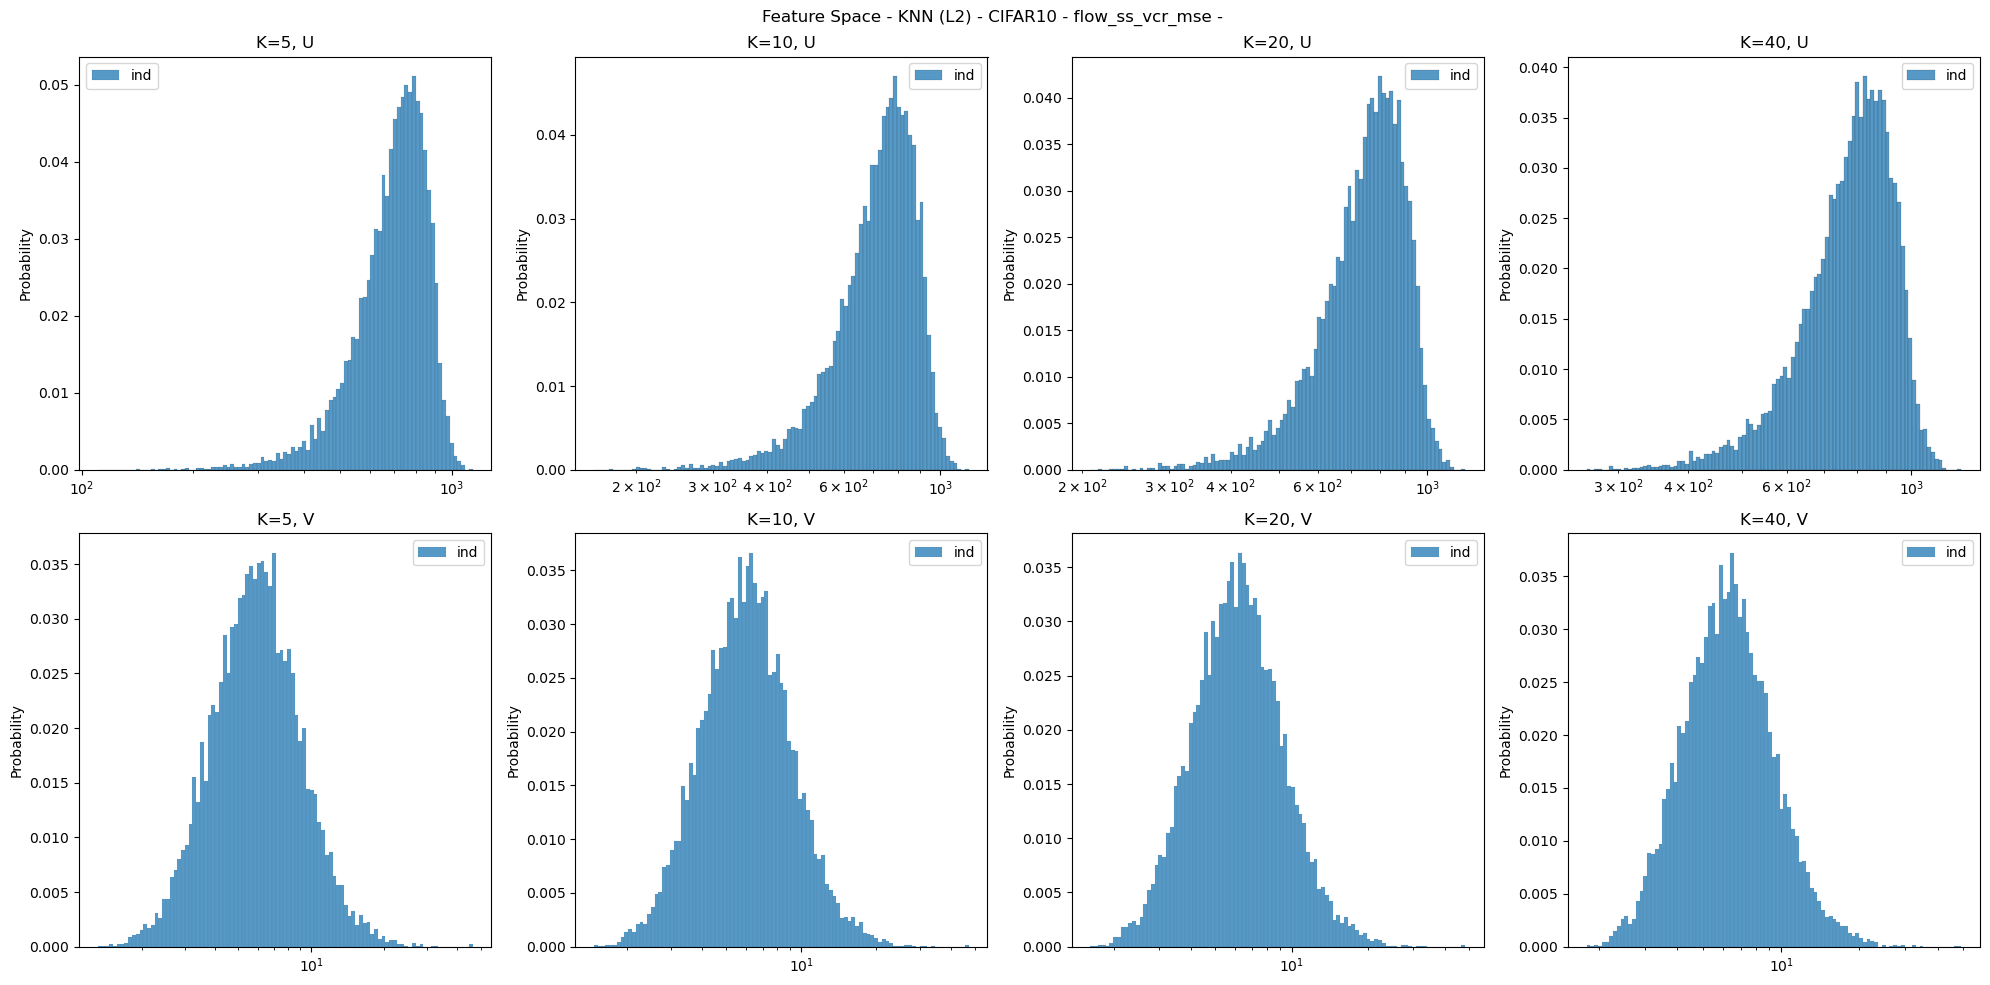

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████                                                                                          | 1/4 [00:00<00:02,  1.32it/s]

 50%|████████████████████████████████████████████████████████████                                                            | 2/4 [00:01<00:01,  1.31it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 3/4 [00:02<00:00,  1.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

  0%|                                                                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████                                                                                          | 1/4 [00:03<00:09,  3.25s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 2/4 [00:06<00:06,  3.25s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 3/4 [00:09<00:03,  3.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.28s/it]

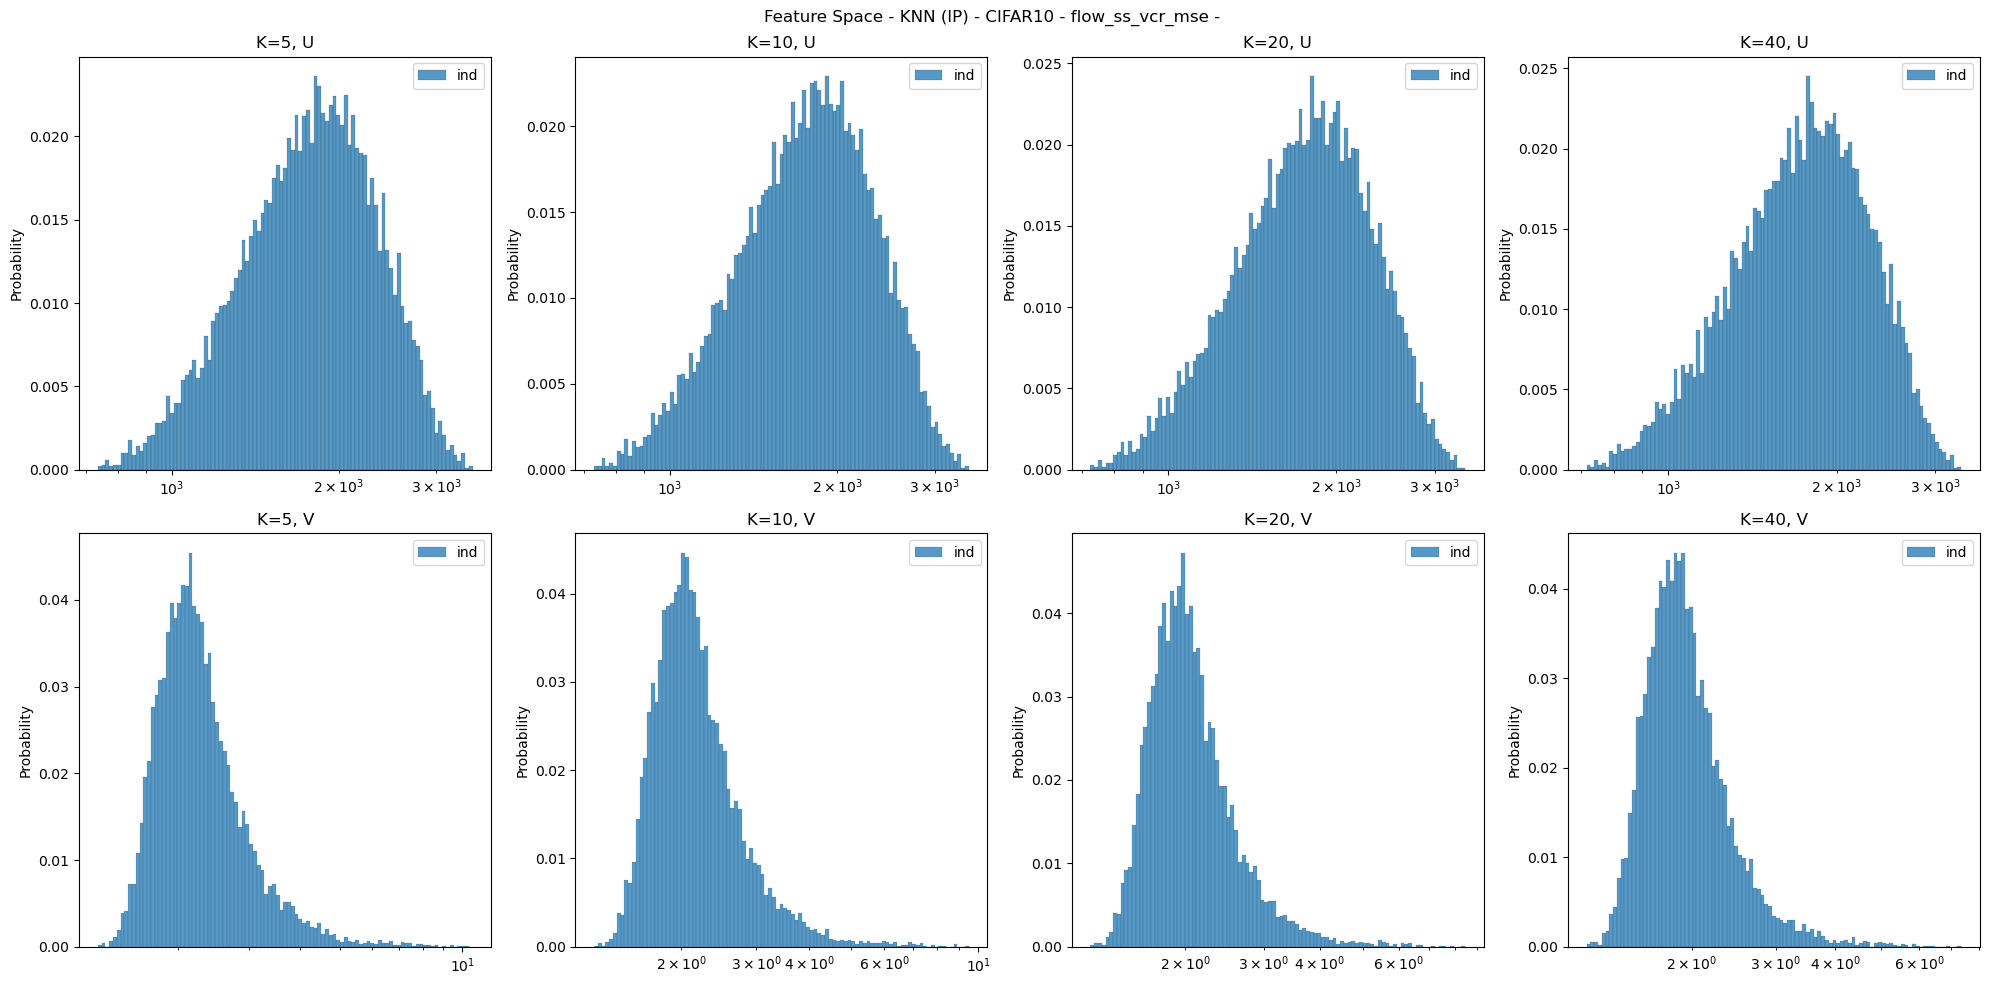

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

42.486694 6.103777 2.5265832 0.53178024
42.430115 6.178843 2.5165703 0.5325616
42.62547 6.135036 2.5249915 0.5312928
59.548553 2.7639012 45.830708 0.7639125


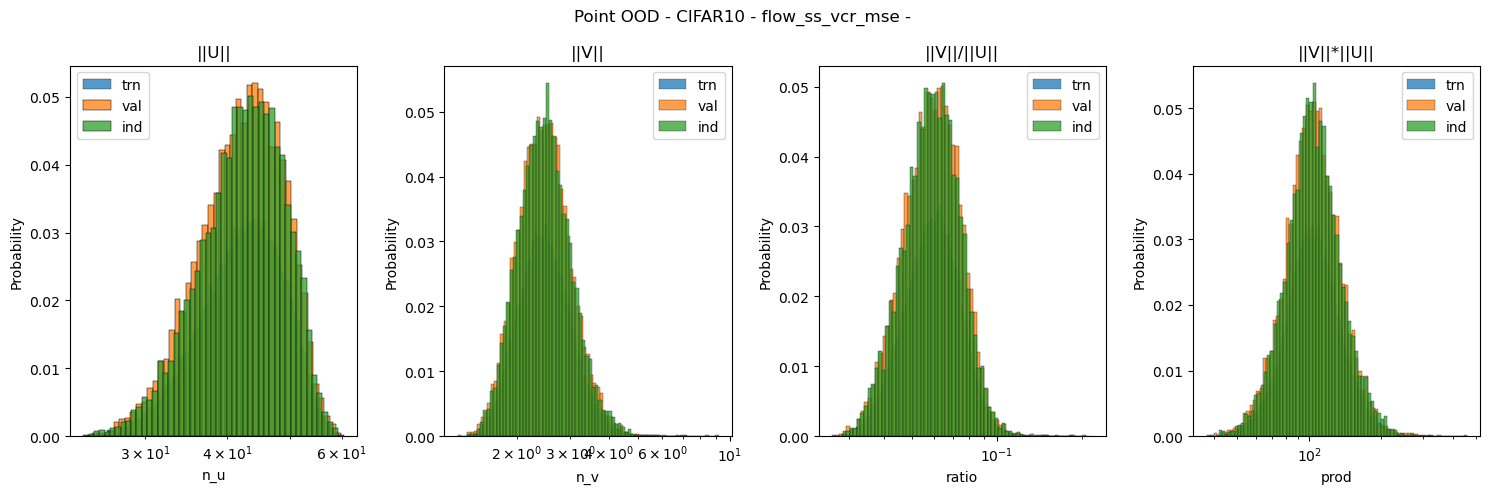

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


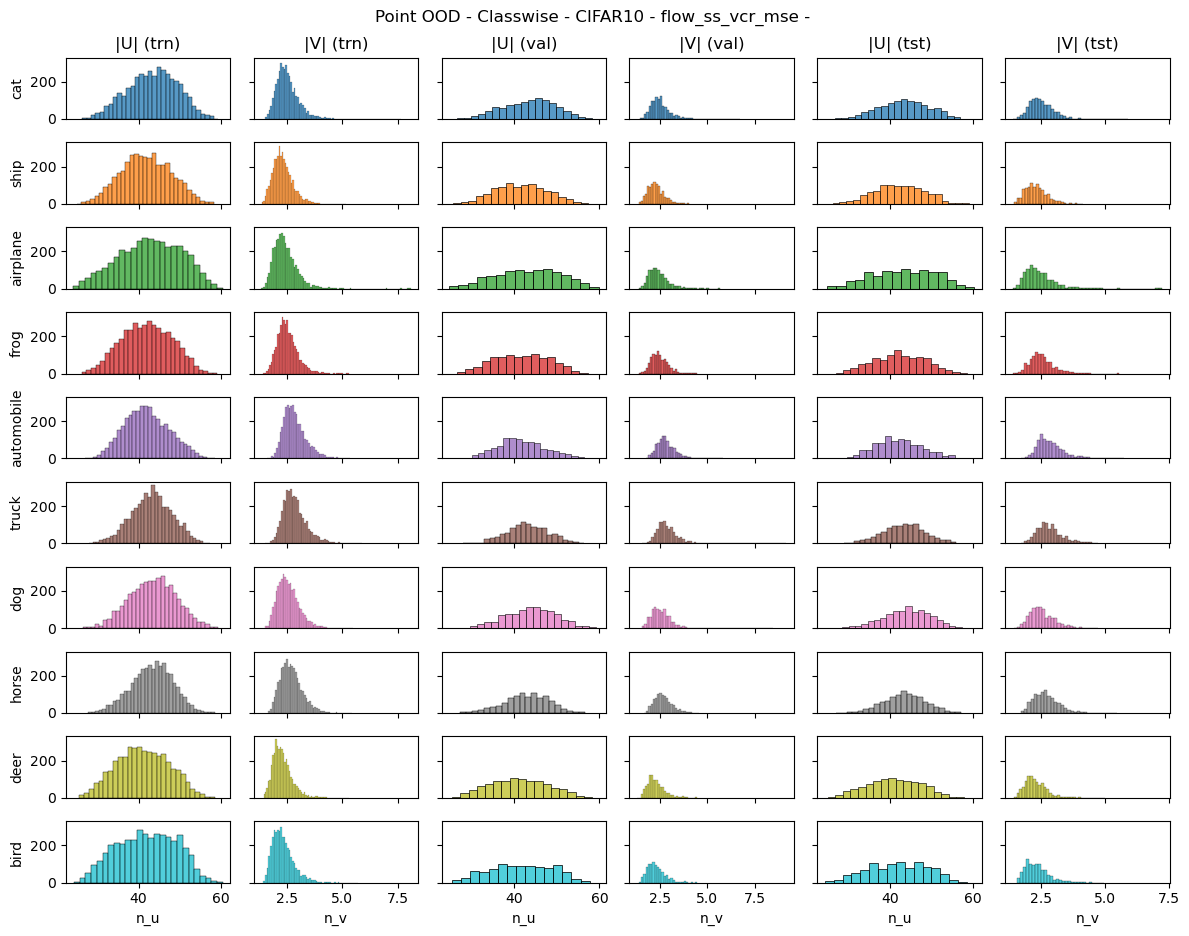

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

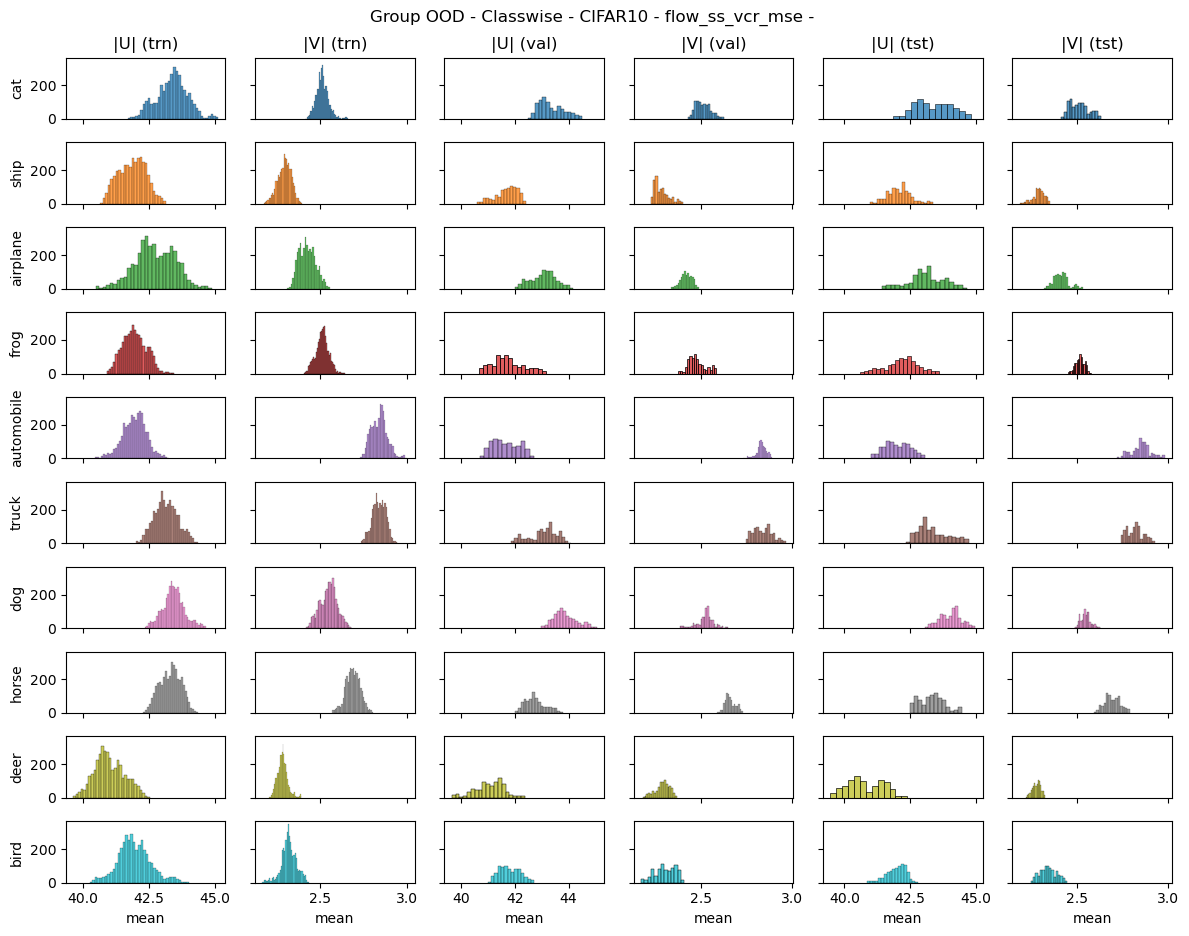

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()